This file is the post-processing script for GPT-4o generated content.

In [23]:
import json
import os
import pprint 
import re
pp = pprint.PrettyPrinter(indent=4)

# dataset_name = 'meme_retrieval_data'
# dataset_name = 'figmemes'
dataset_name = 'memecap'

img_prompt_respond_file = ''
if dataset_name == 'meme_retrieval_data':
    img_prompt_respond_file = '../data/meme_retrieval_data/img_prompt_respond_1-33283.json' # img_prompt_respond_1-33283.json
elif dataset_name == 'figmemes':
    img_prompt_respond_file = '../data/figmemes/img_prompt_respond_1-1542_figmemes.json'
elif  dataset_name == 'memecap':
    img_prompt_respond_file = '../data/memecap/img_prompt_respond_1-559_memecap.json'

meme_configs = []
with open(img_prompt_respond_file, 'r', encoding='utf-8') as json_file:
    meme_configs = json.load(json_file)
len(meme_configs)


559

In [24]:


# attributes = ['visual elaboration', 'detected text', 
#               'meaning of the meme', 'literary device', 'emotion word']

'''
Invalid response cases for 'visual elaboration':
1. No such information;
2. Empty response;

Invalid response cases for 'detected text':
1. No such information;
2. Missing keywords;

Invalid response cases for 'literary device':
1. Missing keywords;
2. Replied with "Category word";
3. Replied with "Chosen word";


Invalid response cases for 'emotion word':
1. Missing keywords;
2. Replied with "Category word";
3. Replied with "Chosen word";


Invalid response cases for 'meaning of the meme':
1. GPT-4o refuses to provide information: "I'm sorry, but I can't assist with that.";
2. Incomplete response, but only restricted to one repeated meme: zzwah.jpg

'''

'\nInvalid response cases for \'visual elaboration\':\n1. No such information;\n2. Empty response;\n\nInvalid response cases for \'detected text\':\n1. No such information;\n2. Missing keywords;\n\nInvalid response cases for \'literary device\':\n1. Missing keywords;\n2. Replied with "Category word";\n3. Replied with "Chosen word";\n\n\nInvalid response cases for \'emotion word\':\n1. Missing keywords;\n2. Replied with "Category word";\n3. Replied with "Chosen word";\n\n\nInvalid response cases for \'meaning of the meme\':\n1. GPT-4o refuses to provide information: "I\'m sorry, but I can\'t assist with that.";\n2. Incomplete response, but only restricted to one repeated meme: zzwah.jpg\n\n'

In [25]:
if dataset_name == 'meme_retrieval_data' or dataset_name == 'memecap':
    literary_device = set("sarcasm, allegory, alliteration, allusion, amplification, anagram, analogy, anthropomorphism, antithesis, chiasmus, circumlocution, euphemism, hyperbole, imagery, metaphor, onomatopoeia, oxymoron, paradox, personification, portmanteau, pun, satire, simile, symbolism, none".split(', '))
elif dataset_name == 'figmemes':
    literary_device = set("allusion, exaggeration, irony, anthrop, metaphor, contrast".split(', '))

emotion_word = set("fear, anger, joy, sadness, surprise, disgust, guilt, contempt, shame, embarrassment, envy, jealousy, love, hate, interest, none".split(', '))
literary_device, emotion_word, len(literary_device), len(emotion_word)

({'allegory',
  'alliteration',
  'allusion',
  'amplification',
  'anagram',
  'analogy',
  'anthropomorphism',
  'antithesis',
  'chiasmus',
  'circumlocution',
  'euphemism',
  'hyperbole',
  'imagery',
  'metaphor',
  'none',
  'onomatopoeia',
  'oxymoron',
  'paradox',
  'personification',
  'portmanteau',
  'pun',
  'sarcasm',
  'satire',
  'simile',
  'symbolism'},
 {'anger',
  'contempt',
  'disgust',
  'embarrassment',
  'envy',
  'fear',
  'guilt',
  'hate',
  'interest',
  'jealousy',
  'joy',
  'love',
  'none',
  'sadness',
  'shame',
  'surprise'},
 25,
 16)

In [26]:
# Counting the number of samples that have 'visual elaboration', 'detected text' and 'meaning of the meme' at the same time.
# If the majority samples satisfy this constriction, then discard the rest.
counter = 0
temp_meme_configs = []
for meme_id, meme_conf in enumerate(meme_configs):
    if ('visual elaboration' in meme_conf['respond'].lower() and
        'detected text' in meme_conf['respond'].lower() and
        'meaning of the meme' in meme_conf['respond'].lower()):
        temp_meme_configs.append(dict(meme_conf))
        counter += 1 

counter

555

In [27]:
# First, handle "\n\n"s in the detected text content
show_example = True
new_meme_configs = [dict(ite) for ite in temp_meme_configs] # Deep copy
for meme_id, meme_conf in enumerate(new_meme_configs):
    # Insert <s> as a delimiter to seperate the first 3 attributes (e.g., visual elaboration, detected text, etc.)
    lines = meme_conf['respond'].split('\n')
    # if "2a4mj4" in meme_conf["image_dir"]:
    #     print(meme_conf["image_dir"], meme_conf['respond'])
    for idx in range(len(lines)):
        if len(lines[idx].strip()) > 0:
            if 'visual elaboration' in lines[idx].lower():
                lines[idx] = '<s>\n' + lines[idx]
            elif 'detected text' in lines[idx].lower():
                lines[idx] = '<s>\n' + lines[idx]
            elif 'meaning of the meme' in lines[idx].lower():
                lines[idx] = '<s>\n' + lines[idx]
            else:
                # print('Outlier: meme_id ', meme_id)
                pass
    meme_conf['respond'] = '\n'.join(lines)
    # if "2a4mj4" in meme_conf["image_dir"]:
    #     print(meme_conf["image_dir"], meme_conf['respond'])

    # Change "\n\n"s in the detected text content into '\n'
    lines = meme_conf['respond'].split('<s>')
    for idx in range(len(lines)):
        if len(lines[idx].strip()) > 0:
            if 'detected text' in lines[idx].lower() and "\n\n" in lines[idx].strip():
                if show_example:
                    print('Image dir:', meme_conf['image_dir'])
                    print('Befoew:', lines[idx])
                    lines[idx] = re.sub(r'\n\n', '\n', lines[idx])
                    print('After:', lines[idx])
                    show_example = False
                else:
                    lines[idx] = re.sub(r'\n\n', '\n', lines[idx])
    meme_conf['respond'] = '<s>'.join(lines)  
    # print(meme_conf['respond'])  

Image dir: ./data/memecap/memes/memes/memes_hg2c5y.png
Befoew: 
Detected Text: 
"KitKat celebrates Gay Month by releasing a new KitKat with no straight lines

falloutmightdeleted I think they meant no parallel lines, because those are still straight.

Who are you, who are so wise in the ways of science?"


After: 
Detected Text: 
"KitKat celebrates Gay Month by releasing a new KitKat with no straight lines
falloutmightdeleted I think they meant no parallel lines, because those are still straight.
Who are you, who are so wise in the ways of science?"



In [28]:
# Second, add <s> before literary device and emotion label
show_example = True
for meme_id, meme_conf in enumerate(new_meme_configs):
    # Insert <s> as a delimiter to seperate the first 3 attributes (e.g., visual elaboration, detected text, etc.)
    lines = meme_conf['respond'].split('\n')
    for idx in range(len(lines)):
        if len(lines[idx].strip()) > 0:
            if ('literary device' in lines[idx].lower() or 
                'word:' in lines[idx].lower() or 
                'category word' in lines[idx].lower() or 
                'chosen word' in lines[idx].lower()):
                lines[idx] = '<s>\n' + lines[idx]
            elif ('emotion word' in lines[idx].lower() or 
                'word:' in lines[idx].lower() or 
                'category word' in lines[idx].lower() or 
                'chosen word' in lines[idx].lower()):
                lines[idx] = '<s>\n' + lines[idx]
    meme_conf['respond'] = '\n'.join(lines)

    # utilizing "\n\n" as a separater to handle cases without attribute keywords.
    meme_conf['respond'] = re.sub(r'\n\n', '\n<s>\n', meme_conf['respond'])
    if show_example:
        print('Image dir:', meme_conf['image_dir'])
        pp.pprint(meme_conf['respond'])
        show_example = False


Image dir: ./data/memecap/memes/memes/memes_d079np.png
('<s>\n'
 'Visual Elaboration (focus on the main content): \n'
 '- The image consists of three parts. The first part shows a happy couple (a '
 "woman and a man) in a selfie. The second part is a close-up of a woman's "
 'hand with a ring on her finger, indicating an engagement or marriage. The '
 'third part is a still image of a man holding a large hammer and confidently '
 'stating "I\'m still worthy!" while smiling.\n'
 '<s>\n'
 '<s>\n'
 'Detected Text: \n'
 '- "NOONECARES.ME"\n'
 '- "Wife Remarries Her Husband After She Falls In Love With Him Again After '
 'Losing Her Memory"\n'
 '- "I\'m still worthy!"\n'
 '<s>\n'
 '<s>\n'
 'Meaning of the Meme (briefly): \n'
 '- The meme humorously suggests that a wife, after losing her memory, fell in '
 'love with and decided to remarry her own husband, indicating his unchanging '
 "worth and likeability as a partner, paralleled by the character's proud "
 'declaration of worthiness regar

In [29]:
# Third, fix mis-seperated labels and remove empty lines
from collections import defaultdict

length_set = defaultdict(lambda: 0)
temp_new_meme_configs = [dict(ite) for ite in new_meme_configs] # Deep copy
for idx, meme_conf in enumerate(temp_new_meme_configs):
    # remove empty lines and possible extra <s>s
    lines = meme_conf['respond'].split('<s>')
    non_empty_lines = [line for line in lines if (len(line.strip()) > 0)]
    if idx < 1:
        print("Before:", meme_conf['respond'])
        print("After:", '<s>'.join(non_empty_lines))
    if len(non_empty_lines) < 5:
        '''
        After: 
        Visual Elaboration (focus on the main content): An image of the "Y U NO" Guy, a character with an exaggerated facial expression and gesturing hands, is presented with text in a blocky, capitalized font.
        <s>
        Detected Text: 
        BRAIN
        WHY U NO WORK DURING TEST
        <s>
        Meaning of the Meme (briefly): The meme humorously expresses frustration with one's brain for not functioning properly or recalling information during an important test, highlighting a common experience of forgetfulness under pressure.
        Sarcasm
        Anger
        '''
        modified_flag = False
        for idx, line in enumerate(non_empty_lines):
            if 'meaning of the meme' in line.lower():
                # Extract words
                words = re.findall(r'\b[A-Za-z]+\b', line)
                if len(words) >=3 :
                    words = words[-3:]
                    for word in words:
                        if word.lower() in literary_device and word.lower() != 'none':
                            print('Before:', non_empty_lines)
                            non_empty_lines.insert(idx+1, "<s>\nliterary device: " + word)
                            non_empty_lines[idx] = re.sub(word, '', line)
                            modified_flag = True
                        if word.lower() in emotion_word and word.lower() != 'none':
                            print('Before:', non_empty_lines)
                            non_empty_lines.append("<s>\nemotion word: " + word)
                            non_empty_lines[idx] = re.sub(word, '', line)
                            modified_flag = True
                    if modified_flag:
                        break
        if modified_flag:
            print("After:", non_empty_lines)
            meme_conf['respond'] = '<s>'.join(non_empty_lines)
    length_set[len(non_empty_lines)] += 1
length_set
 

Before: <s>
Visual Elaboration (focus on the main content): 
- The image consists of three parts. The first part shows a happy couple (a woman and a man) in a selfie. The second part is a close-up of a woman's hand with a ring on her finger, indicating an engagement or marriage. The third part is a still image of a man holding a large hammer and confidently stating "I'm still worthy!" while smiling.
<s>
<s>
Detected Text: 
- "NOONECARES.ME"
- "Wife Remarries Her Husband After She Falls In Love With Him Again After Losing Her Memory"
- "I'm still worthy!"
<s>
<s>
Meaning of the Meme (briefly): 
- The meme humorously suggests that a wife, after losing her memory, fell in love with and decided to remarry her own husband, indicating his unchanging worth and likeability as a partner, paralleled by the character's proud declaration of worthiness regarding his hammer.
<s>
<s>
Literary Device: 
- Analogy
<s>
<s>
Emotion Word: 
- Joy
After: 
Visual Elaboration (focus on the main content): 
- Th

defaultdict(<function __main__.<lambda>()>, {5: 538, 6: 7, 8: 1, 4: 9})

In [30]:
# Verification
length_set = defaultdict(lambda: 0)
for idx, meme_conf in enumerate(temp_new_meme_configs):
    lines = meme_conf['respond'].split('<s>')
    non_empty_lines = [line for line in lines if (len(line.strip()) > 0)]
    length_set[len(non_empty_lines)] += 1
length_set

defaultdict(<function __main__.<lambda>()>, {5: 538, 6: 7, 8: 1, 4: 9})

## Extract the first three attributes 

In [31]:
meme_configs_with_s = [dict(ite) for ite in temp_new_meme_configs] # Deep copy
for idx, meme_conf in enumerate(meme_configs_with_s):
    lines = meme_conf['respond'].split('<s>')
    non_empty_lines = [line for line in lines if (len(line.strip()) > 0)]

    # Extract "visual elaboration", "detected text" and "meaning of the meme"
    for i in range(len(non_empty_lines)):
        if 'visual elaboration' in non_empty_lines[i].lower():
            temp = non_empty_lines[i].split(':')
            if (len(temp) > 1) and (not ('visual elaboration' in meme_conf.keys())):
                meme_conf['visual elaboration'] = ''.join(temp[1:]).strip()
            else:
                # print(f"XXXXXXXX: visual elaboration: {non_empty_lines[i]}")
                pass

        elif 'detected text' in non_empty_lines[i].lower():
            temp = non_empty_lines[i].split(':')
            if (len(temp) > 1) and (not ('detected text' in meme_conf.keys())):
                meme_conf['detected text'] = ''.join(temp[1:]).strip()
            else:
                # print(f"XXXXXXXX: detected text: {non_empty_lines[i]}")
                pass

        elif 'meaning of the meme' in non_empty_lines[i].lower():
            temp = non_empty_lines[i].split(':')
            if (len(temp) > 1) and (not ('meaning of the meme' in meme_conf.keys())):
                meme_conf['meaning of the meme'] = ''.join(temp[1:]).strip()
            else:
                # print(f"XXXXXXXX: meaning of the meme: {non_empty_lines[i]}")
                pass
        else:
            pass
    
    try:
        # seperate the first three atributes and the last two labels
        meme_conf['respond'] = meme_conf['respond'].split(meme_conf['meaning of the meme'])[-1]
    except:
        pass
    if idx < 3:
        pp.pprint(meme_conf)
        print('\n===========\n')



{   'detected text': '- "NOONECARES.ME"\n'
                     '- "Wife Remarries Her Husband After She Falls In Love '
                     'With Him Again After Losing Her Memory"\n'
                     '- "I\'m still worthy!"',
    'image_dir': './data/memecap/memes/memes/memes_d079np.png',
    'meaning of the meme': '- The meme humorously suggests that a wife, after '
                           'losing her memory, fell in love with and decided '
                           'to remarry her own husband, indicating his '
                           'unchanging worth and likeability as a partner, '
                           "paralleled by the character's proud declaration of "
                           'worthiness regarding his hammer.',
    'prompt': 'Here is the context of the meme: "He did it". First, based the '
              'given context, read the text in this image and explain the '
              'meme. Then, provide information for the following categories: \n'
             

# Extract literary device and emotion labels

In [32]:
for idx, meme_conf in enumerate(meme_configs_with_s):
    splited_respond = meme_conf['respond'].split('<s>')
    splited_respond = [line for line in splited_respond if (len(line.strip()) > 0)]
    if idx < 100:
        print(len(splited_respond), splited_respond)

2 ['\nLiterary Device: \n- Analogy\n', '\nEmotion Word: \n- Joy']
2 ['\nChosen Literary Device: satire\n', '\nChosen Emotion Word: surprise']
2 ['\nLiterary Device: Satire\n', '\nEmotion: Interest']
2 ['\nChosen word: Onomatopoeia\n', '\nChosen word: Fear']
2 ['\nChosen Literary Device: Hyperbole\n', '\nChosen Emotion Word: Amusement']
2 ['\nCategory word: Sarcasm\n', '\nEmotion word: Contempt']
2 ['\nChosen Literary Device: \nHyperbole\n', '\nChosen Emotion Word: \nAnger']
2 ['\nChosen Literary Device Word:\n- Satire\n', '\nChosen Emotion Word:\n- Contempt']
2 ['\nChosen Literary Device: \nPersonification\n', '\nChosen Emotion Word: \nSadness']
2 ['\nChosen literary device: Metaphor \n', '\nChosen emotion: Joy']
2 ['\nChosen Literary Device: Hyperbole\n', '\nChosen Emotion Word: Interest']
2 ['\nChosen Literary Device Word: Hyperbole\n', '\nChosen Emotion Word: Disgust']
2 ['\nChosen Literary Device: Irony\n', '\nChosen Emotion Word: Joy']
2 ['\nLiterary Device:\nSarcasm\n', '\nEmotio

In [33]:
number_of_unhandled_cases = 0
meme_configs_5_attributes = []
for idx, meme_conf in enumerate(meme_configs_with_s):
    splited_respond = meme_conf['respond'].split('<s>')
    splited_respond = [line for line in splited_respond if (len(line.strip()) > 0)]

    if len(splited_respond) == 2:
        # ld_ew_counter += 1
        temp = splited_respond[0].split(':') # (with ":")
        if (len(temp) > 1):
            # Define the regular expression pattern for an English word
            # Find all occurrences that match the pattern
            # Strip special tokens
            matches = re.findall(r'\b[A-Za-z]+\b', temp[1].strip())
            if len(matches) > 0:
                meme_conf['literary device'] = matches[0].lower()
        else: # Handle pattern: '<s> Hyperbole <s> Anger' (without ":")
            extracted_word = re.findall(r'\b[A-Za-z]+\b', splited_respond[0].strip())
            for ld_word in extracted_word:
                if ld_word.lower() in literary_device:
                    meme_conf['literary device'] = ld_word.lower()
                    break    

        temp = splited_respond[1].split(':')
        if (len(temp) > 1):
            matches = re.findall(r'\b[A-Za-z]+\b', temp[1].strip())
            if len(matches) > 0:
                meme_conf['emotion word'] = matches[0].lower()
        else: # Handle pattern: '<s> Hyperbole <s> Anger' (without ":")
            extracted_word = re.findall(r'\b[A-Za-z]+\b', splited_respond[1].strip())
            for ew_word in extracted_word:
                if ew_word.lower() in emotion_word:
                    meme_conf['emotion word'] = ew_word.lower()
                    break  

    else: # Handle cases without two <s>s
        words = re.findall(r'\b[A-Za-z]+\b', meme_conf['respond'])
        # "None" and labels outside the candidate set are discarded for simplify the process. 
        for word in words:
            if word.lower() != 'none' and word.lower() in literary_device:
                meme_conf['literary device'] = word.lower()
            if word.lower() != 'none' and word.lower() in emotion_word:
                meme_conf['emotion word'] = word.lower()
    
# attributes = ['visual elaboration', 'detected text', 
#               'meaning of the meme', 'literary device', 'emotion word']
    if not ('visual elaboration' in meme_conf.keys() and
            'detected text' in meme_conf.keys() and
            'meaning of the meme'in meme_conf.keys() and
            'literary device' in meme_conf.keys() and
            'emotion word' in meme_conf.keys()):
        number_of_unhandled_cases += 1
    else:
        meme_conf.pop("respond")
        meme_conf.pop("prompt")
        meme_configs_5_attributes.append(dict(meme_conf))
number_of_unhandled_cases

6

In [34]:
print(len(meme_configs_5_attributes))
with open(f"meme_configs_5_attributes.json", "w") as outfile: 
      json.dump(meme_configs_5_attributes, outfile, indent=4)

549


# Statistics and post-check

In [35]:

img_prompt_respond_file = 'meme_configs_5_attributes.json'
p_IC_DT_MC_LD_EW_img_prompt_respond = []
with open(img_prompt_respond_file, 'r', encoding='utf-8') as json_file:
        p_IC_DT_MC_LD_EW_img_prompt_respond = json.load(json_file)


In [36]:
def str_length_statistics(dataset):
    ic_label_length = []
    dt_label_length = []
    mc_label_length = []
    ld_label_length = []
    ew_label_length = []

    for ite in dataset:
        ic_label_length.append(len(ite['visual elaboration'].split()))
        dt_label_length.append(len(ite['detected text'].split()))
        mc_label_length.append(len(ite['meaning of the meme'].split()))
        ld_label_length.append(len(ite['literary device'].split()))
        ew_label_length.append(len(ite['emotion word'].split()))

    print(set(ic_label_length))
    print(set(dt_label_length))
    print(set(mc_label_length))
    print(set(ld_label_length)) # Good, only 1
    print(set(ew_label_length)) # Good, only 1

    import pandas as pd
    import matplotlib.pyplot as plt
    # Create a DataFrame from the lists
    data = {
        'visual elaboration': ic_label_length,
        'detected text': dt_label_length,
        'meaning of the meme': mc_label_length,
        'literary device': ld_label_length,
        'emotion word': ew_label_length
    }
    df = pd.DataFrame(data)

    # Display the DataFrame
    print(df)

    # Plot a boxplot
    plt.figure(figsize=(10, 6))
    df.boxplot()
    plt.title('The distribution of the lengths of responses')
    plt.ylabel('No. of words')
    plt.show()


549
{0, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 71, 72, 75, 76, 78, 83, 85, 87, 88, 91, 115}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 49, 53, 63, 64, 77}
{15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 58, 59, 60, 64, 69, 73}
{1}
{1}
     visual elaboration  detected text  meaning of the meme  literary device  \
0                    65             23                   43                1   
1                    25             10                   34                1   
2                    67              8                   19                1   
3   

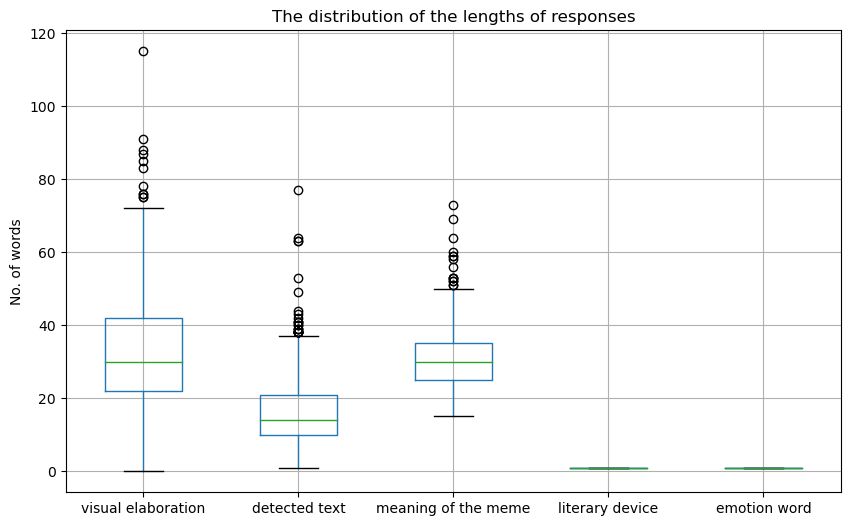

In [37]:
print(len(p_IC_DT_MC_LD_EW_img_prompt_respond))
str_length_statistics(p_IC_DT_MC_LD_EW_img_prompt_respond)

In [38]:
filtered_meme_configs_5_attributes = []
invalid_ld_labels = set()
invalid_ew_labels = set()
number_of_mislabeled_samples = 0

for idx in range(len(p_IC_DT_MC_LD_EW_img_prompt_respond)):
    ld = p_IC_DT_MC_LD_EW_img_prompt_respond[idx]['literary device'].lower()
    ew = p_IC_DT_MC_LD_EW_img_prompt_respond[idx]['emotion word'].lower()
    if (len(p_IC_DT_MC_LD_EW_img_prompt_respond[idx]['visual elaboration'].split()) >= 4 and 
        len(p_IC_DT_MC_LD_EW_img_prompt_respond[idx]['meaning of the meme'].split()) >= 4 and 
        ld in literary_device and 
        ew in emotion_word):
        # p_IC_DT_MC_LD_EW_img_prompt_respond[idx].pop("respond")
        filtered_meme_configs_5_attributes.append(p_IC_DT_MC_LD_EW_img_prompt_respond[idx]) 
    if not ld in literary_device or not ew in emotion_word:
        number_of_mislabeled_samples += 1
    if not ld in literary_device:
        invalid_ld_labels.add(ld) 
    if not ew in emotion_word:
        invalid_ew_labels.add(ew)
         
print('Number of samples after filtering:', len(filtered_meme_configs_5_attributes))
print("invalid_ld_labels:", invalid_ld_labels)
print("invalid_ew_labels:", invalid_ew_labels)
print("number_of_mislabeled_samples:", number_of_mislabeled_samples)
with open(f"filtered_meme_configs_5_attributes.json", "w") as outfile: 
      json.dump(filtered_meme_configs_5_attributes, outfile, indent=4)

Number of samples after filtering: 464
invalid_ld_labels: {'ampliification', 'humor', 'irony'}
invalid_ew_labels: {'amusement', 'defiance', 'humor', 'frustration', 'indifference', 'annoyance', 'regret', 'nostalgia', 'panic', 'confusion', 'satisfaction', 'determination', 'resentment', 'disappointment'}
number_of_mislabeled_samples: 83


{6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 71, 72, 75, 76, 78, 85, 87, 88, 91, 115}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 49, 53, 63, 64, 77}
{15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 58, 59, 64, 69, 73}
{1}
{1}
     visual elaboration  detected text  meaning of the meme  literary device  \
0                    65             23                   43                1   
1                    25             10                   34                1   
2                    67              8                   19                1   
3                    30

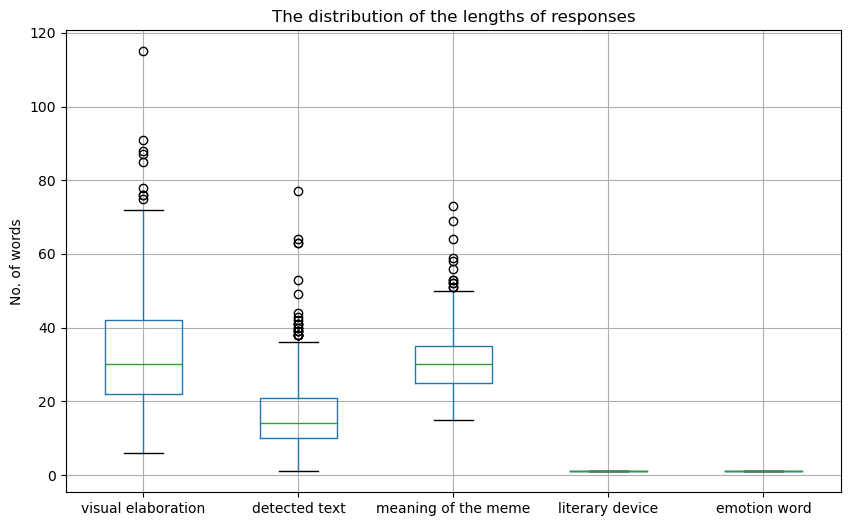

In [39]:
str_length_statistics(filtered_meme_configs_5_attributes)

# Label distribution

In [40]:
literary_device_label_dict = defaultdict(lambda: 0)
emotion_label_dict= defaultdict(lambda: 0)

for idx, meme_conf in enumerate(filtered_meme_configs_5_attributes):
    literary_device_label_dict[meme_conf['literary device']] += 1
    emotion_label_dict[meme_conf['emotion word']] += 1
pp.pprint(literary_device_label_dict)
pp.pprint(emotion_label_dict)

defaultdict(<function <lambda> at 0x7f3ac82a40e0>,
            {   'allegory': 1,
                'alliteration': 1,
                'allusion': 22,
                'analogy': 22,
                'anthropomorphism': 3,
                'antithesis': 39,
                'chiasmus': 5,
                'euphemism': 3,
                'hyperbole': 163,
                'metaphor': 17,
                'none': 12,
                'onomatopoeia': 3,
                'oxymoron': 2,
                'paradox': 22,
                'personification': 8,
                'pun': 27,
                'sarcasm': 30,
                'satire': 81,
                'symbolism': 3})
defaultdict(<function <lambda> at 0x7f3a83cfe480>,
            {   'anger': 22,
                'contempt': 54,
                'disgust': 64,
                'embarrassment': 26,
                'fear': 17,
                'guilt': 4,
                'interest': 82,
                'joy': 62,
                'love': 2,
            

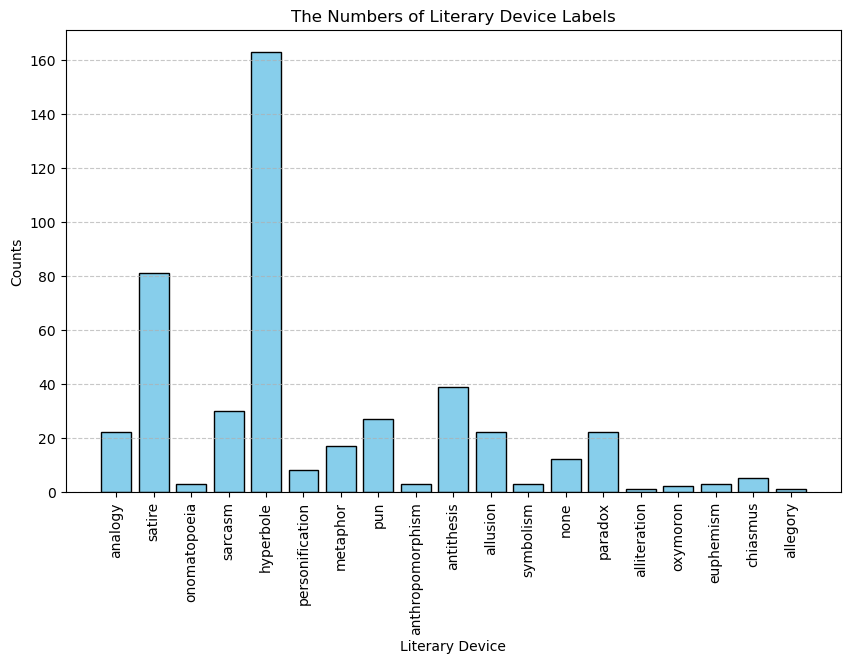

In [41]:
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary
keys = list(literary_device_label_dict.keys())
values = list(literary_device_label_dict.values())

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)

plt.title('The Numbers of Literary Device Labels')
plt.xlabel('Literary Device')
plt.ylabel('Counts')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


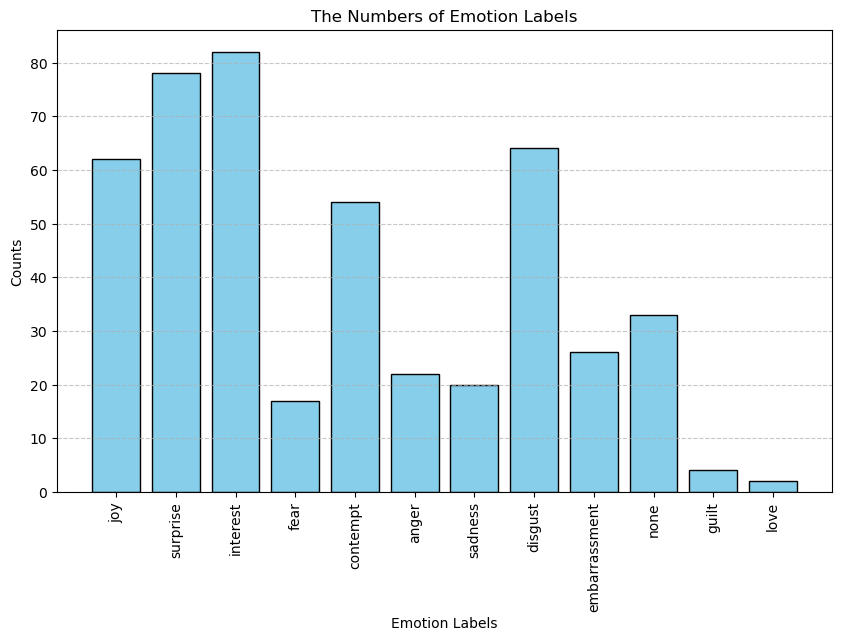

In [42]:
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary
keys = list(emotion_label_dict.keys())
values = list(emotion_label_dict.values())

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)

plt.title('The Numbers of Emotion Labels')
plt.xlabel('Emotion Labels')
plt.ylabel('Counts')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
